In [29]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import time
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from tests_hw4 import test_prediction, test_generation
from tqdm import tqdm
from torchnlp.nn import LockedDropout

In [30]:
# load all that we need

dataset = np.load('../dataset/wiki.train.npy', allow_pickle=True)
devset = np.load('../dataset/wiki.valid.npy', allow_pickle=True)
fixtures_pred = np.load('../fixtures/prediction.npz')  # dev
fixtures_gen = np.load('../fixtures/generation.npy')  # dev
fixtures_pred_test = np.load('../fixtures/prediction_test.npz')  # test
fixtures_gen_test = np.load('../fixtures/generation_test.npy')  # test
vocab = np.load('../dataset/vocab.npy')

In [31]:
# data loader
import random
class LanguageModelDataLoader(DataLoader):
    """
        TODO: Define data loader logic here
    """
    def __init__(self, dataset, batch_size, shuffle=True):

       self.dataset = dataset
       # dataset: 579 dataset[0]: 3803
       self.batch_size = batch_size
       self.shuffle = shuffle 
       self.seq_len = 90
       self.word_len = sum([len(data) for data in self.dataset])
    #    print(self.word_len)
       self.num_batch = (((self.word_len-1)//self.seq_len + 1)- 1)//self.batch_size + 1

    def __len__(self):
        return self.num_batch
        
    def __iter__(self):
        # concatenate your articles and build into batches
        dataset_len = len(self.dataset)
        data_ids = list(range(dataset_len))
        
        # . Randomly shuffle all the articles from the WikiText-2 dataset.
        if self.shuffle:
            random.shuffle(data_ids)
        seq = []
        # 2. Concatenate all text in one long string.
        for id in data_ids:
            seq += list(self.dataset[id])

        # 3. Group the sequences into batches.
        # Calculate the number of batches based on concatenated size and batch size
        num_samples = len(seq) - self.seq_len

        sample_id = 0
        batchx = []
        batchy = []
        
        for i in range(0, num_samples, self.seq_len):
            label = seq[i: i+self.seq_len]
            target = seq[i+1: i+self.seq_len+1]
            sample_id+=1
            batchx.append(torch.LongTensor(label))
            batchy.append(torch.LongTensor(target))
            if  sample_id%self.batch_size==0 or i==num_samples-1:
                yield (torch.stack(batchx), torch.stack(batchy))
                batchx = []
                batchy = []

        print('done')

        
# ld = LanguageModelDataLoader(dataset, batch_size=2, shuffle=True)
# len(ld)
        

In [32]:
# model

class LanguageModel(nn.Module):
    """
        TODO: Define your model here
    """
    def __init__(self, vocab_size):
        super(LanguageModel, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = 400
        self.hid_dim = 1150

        # Embedding layer that maps vocab size dim input to a pre-defined dim vector
        self.embedding = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.embedding_dim,)

        self.lstm1 = nn.LSTM(input_size = self.embedding_dim, hidden_size = self.hid_dim, num_layers=1, 
                            batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(input_size = self.hid_dim*2, hidden_size = self.hid_dim, num_layers=1, 
                            batch_first=True, bidirectional=True)
        self.lstm3 = nn.LSTM(input_size = self.hid_dim*2, hidden_size = self.hid_dim, num_layers=1, 
                            batch_first=True, bidirectional=True)
        
  
        # Linear classifier which maps from LSTM hidden dim back to vocab size dim
        # self.clf = nn.Linear(self.embedding_dim, self.vocab_size)
        self.clf = nn.Linear(self.hid_dim*2, self.vocab_size)
        nn.init.uniform_(self.embedding.weight.data, a=-0.1, b=0.1)

        # for name, param in self.lstm.named_parameters():
        #     self.initialize_weights(param)
            
        # Keeping the shapes consistent allows you to use weight tying here between
        # embedding layer and the linear classifier
        # self.clf.weight = self.embedding.weight


    def forward(self, x):
        # Feel free to add extra arguments to forward (like an argument to pass in the hiddens)
        # the likelihood of the occurrence of a word based on the previous words. 
        # Therefore, the input of your model is the previous text.
        # x = torch.LongTensor(x)
        x = torch.tensor(x).to(device)
        emb = self.embedding(x)
        out, hidden = self.lstm1(emb)
        # out = self.dropout1(out)
        out, hidden = self.lstm2(out, hidden)
        # out = self.dropout2(out)
        # print(out.shape,hidden[0].shape)
        out, (_, _) = self.lstm3(out, hidden)
        # out = self.linear(out)
        # out = self.dropout3(out)
        logits = self.clf(out)
        return logits    


In [33]:
# model trainer

class LanguageModelTrainer:
    def __init__(self, model, loader, max_epochs=1, run_id='exp'):
        """
            Use this class to train your model
        """
        # feel free to add any other parameters here
        self.model = model
        self.loader = loader
        self.train_losses = []
        self.val_losses = []
        self.predictions = []
        self.predictions_test = []
        self.generated_logits = []
        self.generated = []
        self.generated_logits_test = []
        self.generated_test = []
        self.epochs = 0
        self.max_epochs = max_epochs
        self.run_id = run_id
        
        # TODO: Define your optimizer and criterion here
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3, weight_decay=0, amsgrad=True)
        self.criterion = nn.CrossEntropyLoss()
        self.scaler = torch.cuda.amp.GradScaler()
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, factor=0.8, patience=3, verbose=True, threshold=1e-2)


    def train(self):
        self.model.train() # set to training mode
        epoch_loss = 0
        num_batches = 0
        batch_bar = tqdm(total=len(self.loader), dynamic_ncols=True, leave=False, position=0, desc='Train') 

        for batch_num, (inputs, targets) in enumerate(self.loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            epoch_loss += self.train_batch(inputs, targets, )
            batch_bar.set_postfix(
                            loss="{:.04f}".format(float(epoch_loss / (batch_num + 1))),
                            lr="{:.04f}".format(float(self.optimizer.param_groups[0]['lr'])))
            batch_bar.update() 

        epoch_loss = epoch_loss / (batch_num + 1)
        self.epochs += 1
        print('[TRAIN]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs + 1, self.max_epochs, epoch_loss))
        self.train_losses.append(epoch_loss)
        # self.scheduler.step(epoch_loss)   


    def train_batch(self, inputs, targets):
        """ 
            TODO: Define code for training a single batch of inputs
        
        """
        self.optimizer.zero_grad()
        with torch.cuda.amp.autocast(): 
            logits = self.model(inputs)
            B, T, C = logits.shape
            loss = self.criterion(logits.reshape((-1, C)), targets.flatten())
        self.scaler.scale(loss)
        self.scaler.step(self.optimizer)
        # loss.backward() # This is a replacement for loss.backward()
        # self.optimizer.step() # This is a replacement for optimizer.step()
        self.scaler.update()
        return loss
    
    def test(self):
        # don't change these
        self.model.eval() # set to eval mode
        predictions = TestLanguageModel.prediction(fixtures_pred['inp'], self.model) # get predictions
        self.predictions.append(predictions)
        generated_logits = TestLanguageModel.generation(fixtures_gen, 10, self.model) # generated predictions for 10 words
        generated_logits_test = TestLanguageModel.generation(fixtures_gen_test, 10, self.model)
        nll = test_prediction(predictions, fixtures_pred['out'])
        generated = test_generation(fixtures_gen, generated_logits, vocab)
        generated_test = test_generation(fixtures_gen_test, generated_logits_test, vocab)
        self.val_losses.append(nll)
        
        self.generated.append(generated)
        self.generated_test.append(generated_test)
        self.generated_logits.append(generated_logits)
        self.generated_logits_test.append(generated_logits_test)
        
        # generate predictions for test data
        predictions_test = TestLanguageModel.prediction(fixtures_pred_test['inp'], self.model) # get predictions
        self.predictions_test.append(predictions_test)
            
        print('[VAL]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs + 1, self.max_epochs, nll))
        return nll

    def save(self):
        # don't change these
        model_path = os.path.join('experiments', self.run_id, 'model-{}.pkl'.format(self.epochs))
        torch.save({'state_dict': self.model.state_dict()},
            model_path)
        np.save(os.path.join('experiments', self.run_id, 'predictions-{}.npy'.format(self.epochs)), self.predictions[-1])
        np.save(os.path.join('experiments', self.run_id, 'predictions-test-{}.npy'.format(self.epochs)), self.predictions_test[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-{}.npy'.format(self.epochs)), self.generated_logits[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-test-{}.npy'.format(self.epochs)), self.generated_logits_test[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-{}.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-{}-test.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated_test[-1])


In [34]:
class TestLanguageModel:
    def prediction(inp, model):
        """
            TODO: write prediction code here
            
            :param inp:
            :return: a np.ndarray of logits
        """
        # takes as input a batch of sequences, 
        # shaped [batch size, sequence length]. 
        # Return the scores for the next word after the provided sequence for each sequence. 
        # The returned array should be [batch size, vocabulary size] (float) 
        # inp = inp.to(device)
        B, seq_len = inp.shape
        logits = model(inp)[:, -1, :]
        return logits.detach().cpu().numpy()
    
        
    def generation(inp, forward, model):
        """
            TODO: write generation code here

            Generate a sequence of words given a starting sequence.
            :param inp: Initial sequence of words (batch size, length)
            :param forward: number of additional words to generate
            :return: generated words (batch size, forward)
        """        

        # predict the next word given an input using theprediction method
        generated_words =[]
        for i in range(forward):
            logits = TestLanguageModel.prediction(inp, model)
            tokens = logits.argmax(axis=1)
            generated_words.append(tokens)
            prev = inp[:, 1:]
            inp = np.concatenate([prev, tokens.reshape(-1,1)], axis=1)
        generated_words = np.stack(generated_words).transpose(1,0)
        return generated_words
        

In [35]:
# TODO: define other hyperparameters here

NUM_EPOCHS = 20
BATCH_SIZE = 128

run_id = str(int(time.time()))
if not os.path.exists('./experiments'):
    os.mkdir('./experiments')
os.mkdir('./experiments/%s' % run_id)
print("Saving models, predictions, and generated words to ./experiments/%s" % run_id)
device = 'cuda'
model = LanguageModel(len(vocab))
# model.load_state_dict(torch.load('/home/ec2-user/hw4p1/hw4/experiments/1651263061/model-7.pkl')['state_dict'])
model = model.to(device)
loader = LanguageModelDataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)
trainer = LanguageModelTrainer(model=model, loader=loader, max_epochs=NUM_EPOCHS, run_id=run_id)

best_nll = 1e30 
for epoch in range(NUM_EPOCHS):
    trainer.train()
    nll = trainer.test()
    if nll < best_nll:
        best_nll = nll
        print("Saving model, predictions and generated output for epoch "+str(epoch)+" with NLL: "+ str(best_nll))
        trainer.save()



Saving models, predictions, and generated words to ./experiments/1651267307


Train:   0%|          | 0/181 [00:00<?, ?it/s]/tmp/ipykernel_2933/2792366076.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(device)


AssertionError: No inf checks were recorded for this optimizer.

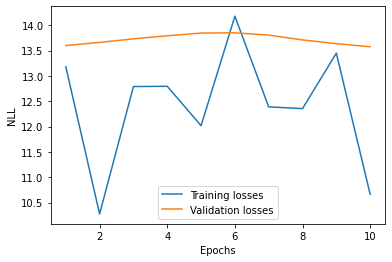

In [ ]:
# Don't change these
# plot training curves
plt.figure()
plt.plot(range(1, trainer.epochs + 1), trainer.train_losses, label='Training losses')
plt.plot(range(1, trainer.epochs + 1), trainer.val_losses, label='Validation losses')
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.legend()
plt.show()

In [ ]:
# see generated output
print (trainer.generated[-1]) # get last generated output